# Set Environment

In [1]:
# 필요 package 설치
!pip install pytorch_tabnet     # tabnet 모델 설치
!pip install catboost           # catboost 모델 설치
!pip install ctgan==0.3.1.dev0  # gan 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 184 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.3 MB 26.9 MB/s 
     |████████████████████████████████| 6.8 MB 87.5 MB/s 
     |████████████████████████████████| 1.1 MB 55.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages 

In [2]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SKKU_study/01_Final_assignment/source/make_module

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1LV52TPokqNSxVzliYdaMCeFRl_ycAZHQ/SKKU_study/01_Final_assignment/source/make_module


In [3]:
# import Custom packages
from model_tabnet import ModelTabnet
from model_forest import ModelForest
from model_catboost import ModelCatBoost
from ensemble_hard import Hard_voting
from ensemble_soft import EnsembleSoft
import Metrics
import sampling

# import packages
from ctgan import CTGANSynthesizer
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
import pandas as pd
import numpy as np
import os
import random
import warnings
warnings.filterwarnings('ignore')

In [4]:
# set directories
main_dir = '/content/drive/MyDrive/SKKU_study/01_Final_assignment'
data_dir = os.path.join(main_dir, 'data')
processed_data_dir = os.path.join(data_dir, 'processed')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(processed_data_dir, exist_ok=True)

# Load Dataset (Vanilla)

In [5]:
dfs = pd.read_csv(os.path.join(processed_data_dir, 'processed.csv'))
train = pd.read_csv(os.path.join(processed_data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(processed_data_dir, 'test.csv'))

all_col_list = [col for col in dfs.columns if col != 'Credit_Score']
train.shape, test.shape # original shape check

((75000, 23), (25000, 23))

# Sampling
- Vanilla: {0: 21782, 1: 40214, 2: 13004}
- SMOTENC: {0: 40214, 1: 40214, 2: 40214}, auto
- SMOTE+Tomeklink: {0: 38217, 1: 37268, 2: 39177}, auto
- GAN: {0: 31393, 1: 40214, 2: 29886}

## SMOTENC

In [6]:
# ratio = {0: 21782, 1: 40214, 2: 13004}
train_smtnc = sampling.train_smote_nc(train, 'auto')
print('sampled with SMOTENC dataset shape %s' % Counter(train_smtnc['Credit_Score']))

sampled with SMOTENC dataset shape Counter({2: 40214, 1: 40214, 0: 40214})


## SMOTE + Tomeklink

In [7]:
# ratio = {0: 21782, 1: 40214, 2: 13004} 
train_smttm = sampling.train_smote_tomek(train, 'auto')
print('sampled with SMOTETOMEK dataset shape %s' % Counter(train_smttm['Credit_Score']))

sampled with SMOTETOMEK dataset shape Counter({2: 39177, 0: 38217, 1: 37268})


## GAN

In [8]:
# gan model은 시간상의 문제로 인해 기존 생성되어 있는 over sampled file 직접 로드하는 형식으로 작성 필요
# train_gan=sampling.train_gan(train)
train_gan = pd.read_csv(os.path.join(data_dir, 'output_GAN_data', 'generate_gan_v4.csv'))
train_gan.drop(columns='Unnamed: 0', inplace=True)

random_list = [] # class 0은 9000개정도 oversampling
for i in range(0, 5000):
    random_list.append(random.randint(0, 12499))
train_gan_0 = train_gan[
    (train_gan.Credit_Score==0) &
    (train_gan.Customer_ID.isin(random_list))
    ]

train_gan_2 = train_gan[train_gan.Credit_Score==2]
train_gan = pd.concat([train_gan_0, train_gan_2], ignore_index=True)
train_gan = pd.concat([train_gan, train], ignore_index=True)
print('sampled with GAN dataset shape %s' % Counter(train_gan['Credit_Score']))

sampled with GAN dataset shape Counter({1: 40214, 0: 31393, 2: 29886})


# Modeling
- 각 모델 단위로 4가지 Sampling (Vanilla, SMOTENC, SMOTE+Tomeklink, GAN) 방식으로 Sampling된 데이터를 Train으로 사용하여 훈련
- 훈련된 모델 중 f1 score (macro)를 기준으로 최적의 Matching (Model X Sampling Method)를 선택
- 총 3개 (best_tabnet, best_rf, best_catboost) model 결과를 ensemble 단계로 전달

## TABNET

### Vanilla

In [9]:
model_tabnet = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
)
tabnet_proba = model_tabnet.predicted_proba

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Occupation :  15
Payment_of_Min_Amount :  3
Payment_Behaviour :  6
!!!Pretrain Start!!!
epoch 0  | loss: 6.09425 |  0:00:07s
epoch 1  | loss: 2.2905  |  0:00:11s
epoch 2  | loss: 1.57758 |  0:00:15s
epoch 3  | loss: 1.25102 |  0:00:19s
epoch 4  | loss: 1.12505 |  0:00:23s
epoch 5  | loss: 1.05401 |  0:00:27s
epoch 6  | loss: 1.03569 |  0:00:31s
epoch 7  | loss: 1.0231  |  0:00:35s
epoch 8  | loss: 1.01646 |  0:00:40s
epoch 9  | loss: 0.99832 |  0:00:44s
epoch 10 | loss: 0.98222 |  0:00:49s
epoch 11 | loss: 0.9711  |  0:00:53s
epoch 12 | loss: 0.96352 |  0:00:57s
epoch 13 | loss: 0.9568  |  0:01:01s
epoch 14 | loss: 0.95315 |  0:01:05s
epoch 15 | loss: 0.94941 |  0:01:09s
epoch 16 | loss: 0.9481  |  0:01:14s
epoch 17 | loss: 0.94443 |  0:01:18s
epoch 18 | loss: 0.93944 |  0:01:22s
epoch 19 | loss: 0.93084 |  0:01:27s
epoch 20 | loss: 0.92692 |  0:01:31s
epoch 21 | loss: 0.92339 |  0:01:35s
epoch 22 | loss: 0.91986 |

In [10]:
# feature importance of tabnet
print('*** Feature Importance of TABNET ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet.model_tabnet.feature_importances_.round(3)[i])

*** Feature Importance of TABNET ***
Customer_ID :  0.69
Month :  0.001
Age :  0.003
Occupation :  0.004
Monthly_Inhand_Salary :  0.0
Num_Bank_Accounts :  0.045
Num_Credit_Card :  0.001
Interest_Rate :  0.005
Num_of_Loan :  0.014
Delay_from_due_date :  0.005
Num_of_Delayed_Payment :  0.011
Changed_Credit_Limit :  0.0
Num_Credit_Inquiries :  0.006
Credit_Mix :  0.007
Outstanding_Debt :  0.112
Credit_Utilization_Ratio :  0.015
Credit_History_Age :  0.018
Payment_of_Min_Amount :  0.0
Total_EMI_per_month :  0.039
Amount_invested_monthly :  0.0
Payment_Behaviour :  0.008
Monthly_Balance :  0.017


In [11]:
# check probability of tabnet predict result
tabnet_proba.head()

,ID,model,Poor,Standard,Good
0,0,TABNET,0.000053,0.017469,0.982478
1,1,TABNET,0.000070,0.015321,0.984610
2,2,TABNET,0.000202,0.082019,0.917779
3,3,TABNET,0.000149,0.113235,0.886617
4,4,TABNET,0.000003,0.010123,0.989875


### SMOTENC

In [12]:
model_tabnet_smtnc = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
    dfs_sampled=train_smtnc,
)
tabnet_proba_smtnc = model_tabnet_smtnc.predicted_proba

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Occupation :  15
Payment_of_Min_Amount :  3
Payment_Behaviour :  6
!!!Pretrain Start!!!
epoch 0  | loss: 4.89142 |  0:00:05s
epoch 1  | loss: 1.63923 |  0:00:11s
epoch 2  | loss: 1.17096 |  0:00:17s
epoch 3  | loss: 1.03153 |  0:00:23s
epoch 4  | loss: 1.00264 |  0:00:29s
epoch 5  | loss: 0.98826 |  0:00:35s
epoch 6  | loss: 0.96339 |  0:00:40s
epoch 7  | loss: 0.94881 |  0:00:46s
epoch 8  | loss: 0.94129 |  0:00:52s
epoch 9  | loss: 0.93632 |  0:00:58s
epoch 10 | loss: 0.93304 |  0:01:04s
epoch 11 | loss: 0.92713 |  0:01:10s
epoch 12 | loss: 0.91996 |  0:01:16s
epoch 13 | loss: 0.91175 |  0:01:21s
epoch 14 | loss: 0.90662 |  0:01:27s
epoch 15 | loss: 0.89986 |  0:01:33s
epoch 16 | loss: 0.89676 |  0:01:39s
epoch 17 | loss: 0.89161 |  0:01:45s
epoch 18 | loss: 0.88968 |  0:01:51s
epoch 19 | loss: 0.88601 |  0:01:56s
epoch 20 | loss: 0.88457 |  0:02:02s
epoch 21 | loss: 0.88382 |  0:02:08s
epoch 22 | loss: 0.8804  |

In [13]:
# feature importance of tabnet x SMOTENC
print('*** Feature Importance of TABNET x SMOTENC ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet_smtnc.model_tabnet.feature_importances_.round(3)[i])

*** Feature Importance of TABNET x SMOTENC ***
Customer_ID :  0.955
Month :  0.003
Age :  0.008
Occupation :  0.0
Monthly_Inhand_Salary :  0.0
Num_Bank_Accounts :  0.009
Num_Credit_Card :  0.0
Interest_Rate :  0.0
Num_of_Loan :  0.001
Delay_from_due_date :  0.0
Num_of_Delayed_Payment :  0.0
Changed_Credit_Limit :  0.0
Num_Credit_Inquiries :  0.002
Credit_Mix :  0.0
Outstanding_Debt :  0.002
Credit_Utilization_Ratio :  0.0
Credit_History_Age :  0.003
Payment_of_Min_Amount :  0.001
Total_EMI_per_month :  0.0
Amount_invested_monthly :  0.0
Payment_Behaviour :  0.012
Monthly_Balance :  0.002


In [14]:
tabnet_proba_smtnc.head()

,ID,model,Poor,Standard,Good
0,0,TABNET,9.790602e-08,0.005177,0.994823
1,1,TABNET,1.303278e-07,0.004731,0.995269
2,2,TABNET,1.146597e-04,0.102358,0.897528
3,3,TABNET,1.989463e-04,0.126034,0.873767
4,4,TABNET,2.111980e-07,0.002788,0.997212


### SMOTE + Tomeklink

In [15]:
model_tabnet_smttm = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
    dfs_sampled=train_smttm,
)
tabnet_proba_smttm = model_tabnet_smttm.predicted_proba

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Occupation :  15
Payment_of_Min_Amount :  3
Payment_Behaviour :  6
!!!Pretrain Start!!!
epoch 0  | loss: 5.00721 |  0:00:05s
epoch 1  | loss: 1.69772 |  0:00:10s
epoch 2  | loss: 1.19906 |  0:00:16s
epoch 3  | loss: 1.05441 |  0:00:21s
epoch 4  | loss: 1.01865 |  0:00:27s
epoch 5  | loss: 1.00255 |  0:00:32s
epoch 6  | loss: 0.98006 |  0:00:38s
epoch 7  | loss: 0.96184 |  0:00:43s
epoch 8  | loss: 0.95253 |  0:00:48s
epoch 9  | loss: 0.94632 |  0:00:54s
epoch 10 | loss: 0.94295 |  0:00:59s
epoch 11 | loss: 0.94017 |  0:01:05s
epoch 12 | loss: 0.93329 |  0:01:10s
epoch 13 | loss: 0.92627 |  0:01:15s
epoch 14 | loss: 0.91948 |  0:01:21s
epoch 15 | loss: 0.91374 |  0:01:26s
epoch 16 | loss: 0.90785 |  0:01:32s
epoch 17 | loss: 0.90463 |  0:01:37s
epoch 18 | loss: 0.90181 |  0:01:43s
epoch 19 | loss: 0.89874 |  0:01:48s
epoch 20 | loss: 0.89695 |  0:01:54s
epoch 21 | loss: 0.89423 |  0:01:59s
epoch 22 | loss: 0.89259 |

In [16]:
# feature importance of tabnet X SMOTETOMEK
print('*** Feature Importance of TABNET X SMOTETOMEK ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet_smttm.model_tabnet.feature_importances_.round(3)[i])

*** Feature Importance of TABNET X SMOTETOMEK ***
Customer_ID :  0.465
Month :  0.0
Age :  0.001
Occupation :  0.0
Monthly_Inhand_Salary :  0.0
Num_Bank_Accounts :  0.009
Num_Credit_Card :  0.003
Interest_Rate :  0.014
Num_of_Loan :  0.023
Delay_from_due_date :  0.023
Num_of_Delayed_Payment :  0.01
Changed_Credit_Limit :  0.009
Num_Credit_Inquiries :  0.0
Credit_Mix :  0.012
Outstanding_Debt :  0.196
Credit_Utilization_Ratio :  0.015
Credit_History_Age :  0.011
Payment_of_Min_Amount :  0.0
Total_EMI_per_month :  0.055
Amount_invested_monthly :  0.068
Payment_Behaviour :  0.014
Monthly_Balance :  0.072


In [17]:
tabnet_proba_smttm.head()

,ID,model,Poor,Standard,Good
0,0,TABNET,0.000018,0.029765,0.970217
1,1,TABNET,0.000006,0.008934,0.991059
2,2,TABNET,0.000006,0.070923,0.929072
3,3,TABNET,0.000017,0.265906,0.734077
4,4,TABNET,0.000116,0.010335,0.989549


### GAN

In [18]:
model_tabnet_gan = ModelTabnet(
    dfs_train=train,
    dfs_test=test,
    dfs_sampled=train_gan,
)
tabnet_proba_gan = model_tabnet_gan.predicted_proba

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Occupation :  15
Payment_of_Min_Amount :  3
Payment_Behaviour :  6
!!!Pretrain Start!!!
epoch 0  | loss: 5.1663  |  0:00:04s
epoch 1  | loss: 1.78202 |  0:00:09s
epoch 2  | loss: 1.2884  |  0:00:14s
epoch 3  | loss: 1.09931 |  0:00:19s
epoch 4  | loss: 1.02937 |  0:00:24s
epoch 5  | loss: 1.01218 |  0:00:29s
epoch 6  | loss: 0.99954 |  0:00:34s
epoch 7  | loss: 0.97634 |  0:00:39s
epoch 8  | loss: 0.96123 |  0:00:44s
epoch 9  | loss: 0.95144 |  0:00:49s
epoch 10 | loss: 0.94563 |  0:00:53s
epoch 11 | loss: 0.9408  |  0:00:58s
epoch 12 | loss: 0.93995 |  0:01:03s
epoch 13 | loss: 0.93673 |  0:01:08s
epoch 14 | loss: 0.92953 |  0:01:13s
epoch 15 | loss: 0.92642 |  0:01:18s
epoch 16 | loss: 0.91996 |  0:01:22s
epoch 17 | loss: 0.91639 |  0:01:27s
epoch 18 | loss: 0.91229 |  0:01:32s
epoch 19 | loss: 0.90994 |  0:01:37s
epoch 20 | loss: 0.90541 |  0:01:42s
epoch 21 | loss: 0.90304 |  0:01:47s
epoch 22 | loss: 0.90089 |

In [19]:
# feature importance of tabnet X GAN
print('*** Feature Importance of TABNET X GAN ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_tabnet_gan.model_tabnet.feature_importances_.round(3)[i])

*** Feature Importance of TABNET X GAN ***
Customer_ID :  0.715
Month :  0.025
Age :  0.001
Occupation :  0.001
Monthly_Inhand_Salary :  0.0
Num_Bank_Accounts :  0.012
Num_Credit_Card :  0.002
Interest_Rate :  0.012
Num_of_Loan :  0.016
Delay_from_due_date :  0.006
Num_of_Delayed_Payment :  0.016
Changed_Credit_Limit :  0.0
Num_Credit_Inquiries :  0.013
Credit_Mix :  0.008
Outstanding_Debt :  0.106
Credit_Utilization_Ratio :  0.016
Credit_History_Age :  0.003
Payment_of_Min_Amount :  0.008
Total_EMI_per_month :  0.004
Amount_invested_monthly :  0.003
Payment_Behaviour :  0.029
Monthly_Balance :  0.004


In [20]:
tabnet_proba_gan.head()

,ID,model,Poor,Standard,Good
0,0,TABNET,1.439851e-05,0.019503,0.980483
1,1,TABNET,2.078245e-06,0.004898,0.995100
2,2,TABNET,7.910874e-06,0.050700,0.949292
3,3,TABNET,6.866179e-05,0.173149,0.826782
4,4,TABNET,9.407469e-07,0.002949,0.997050


### Select Best Model with TABNET

In [22]:
# acc_vanilla = accuracy_score(test['Credit_Score'], model_tabnet.predict['predict'])
# acc_smtnc = accuracy_score(test['Credit_Score'], model_tabnet_smtnc.predict['predict'])
# acc_smttm = accuracy_score(test['Credit_Score'], model_tabnet_smttm.predict['predict'])
# acc_gan = accuracy_score(test['Credit_Score'], model_tabnet_gan.predict['predict'])

acc_vanilla = f1_score(test['Credit_Score'], model_tabnet.predict['predict'], average='macro')
acc_smtnc = f1_score(test['Credit_Score'], model_tabnet_smtnc.predict['predict'], average='macro')
acc_smttm = f1_score(test['Credit_Score'], model_tabnet_smttm.predict['predict'], average='macro')
acc_gan = f1_score(test['Credit_Score'], model_tabnet_gan.predict['predict'], average='macro')

accuracy_dict = {
    'Vanilla': acc_vanilla,
    'SMOTENC': acc_smtnc,
    'SMOTETOMEK': acc_smttm,
    'GAN': acc_gan,
}
best_acc = max(accuracy_dict.values())
best_model_idx = list(accuracy_dict.values()).index(best_acc)
best_model = list(accuracy_dict.keys())[best_model_idx]
# print('Best TABNET accuracy is ', best_acc, 'with ', best_model)
print('Best TABNET f1 score is ', best_acc, 'with ', best_model)

if best_model == 'Vanilla':
    best_tabnet = model_tabnet
elif best_model == 'SMOTENC':
    best_tabnet = model_tabnet_smtnc
elif best_model == 'SMOTETOMEK':
    best_tabnet = model_tabnet_smttm
else:
    best_tabnet = model_tabnet_gan

Best TABNET f1 score is  0.750278083301651 with  SMOTETOMEK


## RF

### Vanilla

In [23]:
model_forest = ModelForest(
    train,
    test,
    "plain"
)
result_forest = model_forest.predict_proba

In [24]:
# feature importance
print('*** Feature Importance of RandomForest ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest.feature_importance.round(3)[i])

*** Feature Importance of RandomForest ***
Customer_ID :  0.042
Month :  0.035
Age :  0.017
Occupation :  0.028
Monthly_Inhand_Salary :  0.046
Num_Bank_Accounts :  0.041
Num_Credit_Card :  0.037
Interest_Rate :  0.095
Num_of_Loan :  0.008
Delay_from_due_date :  0.072
Num_of_Delayed_Payment :  0.038
Changed_Credit_Limit :  0.015
Num_Credit_Inquiries :  0.059
Credit_Mix :  0.104
Outstanding_Debt :  0.122
Credit_Utilization_Ratio :  0.039
Credit_History_Age :  0.016
Payment_of_Min_Amount :  0.038
Total_EMI_per_month :  0.043
Amount_invested_monthly :  0.042
Payment_Behaviour :  0.019
Monthly_Balance :  0.043


In [25]:
result_forest.head()

,ID,model,Poor,Standard,Good
0,0,RF,0.04,0.22,0.74
1,1,RF,0.01,0.13,0.86
2,2,RF,0.02,0.30,0.68
3,3,RF,0.04,0.29,0.67
4,4,RF,0.01,0.03,0.96


### SmoteNC

In [26]:
model_forest_smtnc = ModelForest(
    train_smtnc,
    test, 
    "plain"
)
forest_proba_smtnc = model_forest_smtnc.predict_proba

In [27]:
# feature importance
print('*** Feature Importance of RandomForest x SMOTETNC ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest_smtnc.feature_importance.round(3)[i])

*** Feature Importance of RandomForest x SMOTETNC ***
Customer_ID :  0.029
Month :  0.028
Age :  0.012
Occupation :  0.02
Monthly_Inhand_Salary :  0.035
Num_Bank_Accounts :  0.051
Num_Credit_Card :  0.038
Interest_Rate :  0.106
Num_of_Loan :  0.008
Delay_from_due_date :  0.068
Num_of_Delayed_Payment :  0.036
Changed_Credit_Limit :  0.017
Num_Credit_Inquiries :  0.07
Credit_Mix :  0.116
Outstanding_Debt :  0.122
Credit_Utilization_Ratio :  0.029
Credit_History_Age :  0.038
Payment_of_Min_Amount :  0.059
Total_EMI_per_month :  0.038
Amount_invested_monthly :  0.033
Payment_Behaviour :  0.014
Monthly_Balance :  0.033


In [28]:
forest_proba_smtnc.head()

,ID,model,Poor,Standard,Good
0,0,RF,0.03,0.14,0.83
1,1,RF,0.02,0.07,0.91
2,2,RF,0.18,0.25,0.57
3,3,RF,0.02,0.18,0.80
4,4,RF,0.04,0.03,0.93


### SMOTE + Tomeklink

In [29]:
model_forest_smttm = ModelForest(
    train_smttm,
    test ,
    "plain"
)
forest_proba_smttm = model_forest_smttm.predict_proba

In [30]:
# feature importance
print('*** Feature Importance of RandomForest x SMOTETOMEK ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest_smttm.feature_importance.round(3)[i])

*** Feature Importance of RandomForest x SMOTETOMEK ***
Customer_ID :  0.033
Month :  0.026
Age :  0.013
Occupation :  0.022
Monthly_Inhand_Salary :  0.036
Num_Bank_Accounts :  0.056
Num_Credit_Card :  0.036
Interest_Rate :  0.118
Num_of_Loan :  0.009
Delay_from_due_date :  0.072
Num_of_Delayed_Payment :  0.036
Changed_Credit_Limit :  0.019
Num_Credit_Inquiries :  0.073
Credit_Mix :  0.088
Outstanding_Debt :  0.131
Credit_Utilization_Ratio :  0.026
Credit_History_Age :  0.035
Payment_of_Min_Amount :  0.06
Total_EMI_per_month :  0.035
Amount_invested_monthly :  0.032
Payment_Behaviour :  0.014
Monthly_Balance :  0.031


In [31]:
forest_proba_smttm.head()

,ID,model,Poor,Standard,Good
0,0,RF,0.08,0.41,0.51
1,1,RF,0.07,0.20,0.73
2,2,RF,0.03,0.21,0.76
3,3,RF,0.06,0.24,0.70
4,4,RF,0.06,0.13,0.81


### GAN

In [32]:
model_forest_gan = ModelForest(
    train_gan,
    test,
    "plain"
)
forest_proba_gan = model_forest_gan.predict_proba

In [33]:
# feature importance
print('*** Feature Importance of RandomForest x GAN ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_forest_gan.feature_importance.round(3)[i])

*** Feature Importance of RandomForest x GAN ***
Customer_ID :  0.036
Month :  0.026
Age :  0.016
Occupation :  0.026
Monthly_Inhand_Salary :  0.041
Num_Bank_Accounts :  0.072
Num_Credit_Card :  0.047
Interest_Rate :  0.103
Num_of_Loan :  0.006
Delay_from_due_date :  0.07
Num_of_Delayed_Payment :  0.041
Changed_Credit_Limit :  0.016
Num_Credit_Inquiries :  0.068
Credit_Mix :  0.086
Outstanding_Debt :  0.111
Credit_Utilization_Ratio :  0.036
Credit_History_Age :  0.018
Payment_of_Min_Amount :  0.044
Total_EMI_per_month :  0.04
Amount_invested_monthly :  0.037
Payment_Behaviour :  0.02
Monthly_Balance :  0.04


In [34]:
forest_proba_gan.head()

,ID,model,Poor,Standard,Good
0,0,RF,0.06,0.17,0.77
1,1,RF,0.06,0.14,0.80
2,2,RF,0.08,0.30,0.62
3,3,RF,0.03,0.27,0.70
4,4,RF,0.01,0.10,0.89


### Select Best Model with RF

In [35]:
# acc_vanilla = accuracy_score(test['Credit_Score'], model_forest.predict['predict'])
# acc_smtnc = accuracy_score(test['Credit_Score'], model_forest_smtnc.predict['predict'])
# acc_smttm = accuracy_score(test['Credit_Score'], model_forest_smttm.predict['predict'])
# acc_gan = accuracy_score(test['Credit_Score'], model_forest_gan.predict['predict'])

acc_vanilla = f1_score(test['Credit_Score'], model_forest.predict['predict'], average='macro')
acc_smtnc = f1_score(test['Credit_Score'], model_forest_smtnc.predict['predict'], average='macro')
acc_smttm = f1_score(test['Credit_Score'], model_forest_smttm.predict['predict'], average='macro')
acc_gan = f1_score(test['Credit_Score'], model_forest_gan.predict['predict'], average='macro')

accuracy_dict = {
    'Vanilla': acc_vanilla,
    'SMOTENC': acc_smtnc,
    'SMOTETOMEK': acc_smttm,
    'GAN': acc_gan
}
best_acc = max(accuracy_dict.values())
best_model_idx = list(accuracy_dict.values()).index(best_acc)
best_model = list(accuracy_dict.keys())[best_model_idx]
print('Best RANDOM FOREST f1 score is ', best_acc, 'with ', best_model)

if best_model == 'Vanilla':
    best_rf = model_forest
elif best_model == 'SMOTENC':
    best_rf = model_forest_smtnc
elif best_model =='GAN':
    best_rf = model_forest_gan
else:
    best_rf = model_forest_smttm

Best RANDOM FOREST f1 score is  0.7318316694962367 with  Vanilla


## CatBoost

### Vanilla

In [36]:
model_catboost = ModelCatBoost(
    train,
    test,
    "optimize"
)

0:	learn: 1.0524323	total: 1.09s	remaining: 18m 6s
1:	learn: 1.0076542	total: 2.03s	remaining: 16m 55s
2:	learn: 0.9684652	total: 2.86s	remaining: 15m 49s
3:	learn: 0.9351590	total: 3.88s	remaining: 16m 7s
4:	learn: 0.9076541	total: 4.92s	remaining: 16m 18s
5:	learn: 0.8829301	total: 5.84s	remaining: 16m 6s
6:	learn: 0.8604031	total: 6.33s	remaining: 14m 57s
7:	learn: 0.8415306	total: 7.25s	remaining: 14m 58s
8:	learn: 0.8292816	total: 8.17s	remaining: 14m 59s
9:	learn: 0.8062957	total: 8.24s	remaining: 13m 36s
10:	learn: 0.7918187	total: 9.18s	remaining: 13m 45s
11:	learn: 0.7827413	total: 10.1s	remaining: 13m 50s
12:	learn: 0.7755620	total: 11s	remaining: 13m 51s
13:	learn: 0.7657157	total: 11.8s	remaining: 13m 49s
14:	learn: 0.7595937	total: 12.6s	remaining: 13m 47s
15:	learn: 0.7517415	total: 13.6s	remaining: 13m 53s
16:	learn: 0.7436451	total: 14.4s	remaining: 13m 51s
17:	learn: 0.7367319	total: 15.2s	remaining: 13m 49s
18:	learn: 0.7323850	total: 16s	remaining: 13m 47s
19:	learn:

In [37]:
print('*** Feature Importance of CatBoost ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_catboost.feature_importance.round(3)[i])

*** Feature Importance of CatBoost ***
Customer_ID :  7.741
Month :  7.155
Age :  6.015
Occupation :  7.572
Monthly_Inhand_Salary :  3.693
Num_Bank_Accounts :  3.375
Num_Credit_Card :  8.191
Interest_Rate :  3.903
Num_of_Loan :  0.125
Delay_from_due_date :  6.946
Num_of_Delayed_Payment :  3.622
Changed_Credit_Limit :  2.981
Num_Credit_Inquiries :  2.947
Credit_Mix :  12.472
Outstanding_Debt :  9.039
Credit_Utilization_Ratio :  1.188
Credit_History_Age :  0.054
Payment_of_Min_Amount :  0.218
Total_EMI_per_month :  6.187
Amount_invested_monthly :  3.301
Payment_Behaviour :  2.128
Monthly_Balance :  1.147


In [38]:
result_catboost = model_catboost.predict_proba
result_catboost.head()

,ID,model,Poor,Standard,Good
0,0,Cat,0.026318,0.091878,0.881804
1,1,Cat,0.016408,0.081157,0.902434
2,2,Cat,0.030228,0.112337,0.857435
3,3,Cat,0.066671,0.196318,0.737011
4,4,Cat,0.088059,0.063696,0.848245


### SMOTENC

In [39]:
model_cat_smtnc = ModelCatBoost(
    train_smtnc,
    test,'optimize'
)
cat_proba_smtnc = model_cat_smtnc.predict_proba

0:	learn: 1.0096966	total: 117ms	remaining: 1m 56s
1:	learn: 0.9438115	total: 1.61s	remaining: 13m 23s
2:	learn: 0.8863103	total: 1.89s	remaining: 10m 28s
3:	learn: 0.8427235	total: 3.47s	remaining: 14m 24s
4:	learn: 0.8074787	total: 5.35s	remaining: 17m 44s
5:	learn: 0.7741480	total: 7.15s	remaining: 19m 45s
6:	learn: 0.7461829	total: 8.75s	remaining: 20m 41s
7:	learn: 0.7226936	total: 10.6s	remaining: 21m 49s
8:	learn: 0.6983778	total: 12.3s	remaining: 22m 33s
9:	learn: 0.6772728	total: 13.8s	remaining: 22m 43s
10:	learn: 0.6584076	total: 15.3s	remaining: 22m 53s
11:	learn: 0.6448495	total: 17s	remaining: 23m 17s
12:	learn: 0.6312760	total: 18.6s	remaining: 23m 30s
13:	learn: 0.6183225	total: 20.1s	remaining: 23m 38s
14:	learn: 0.6076494	total: 21.7s	remaining: 23m 45s
15:	learn: 0.5963047	total: 22.1s	remaining: 22m 36s
16:	learn: 0.5890166	total: 23.7s	remaining: 22m 48s
17:	learn: 0.5778130	total: 23.8s	remaining: 21m 36s
18:	learn: 0.5723500	total: 25.3s	remaining: 21m 45s
19:	le

In [40]:
# feature importance
print('*** Feature Importance of CATBOOST x SMOTETNC ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_cat_smtnc.feature_importance.round(3)[i])

*** Feature Importance of CATBOOST x SMOTETNC ***
Customer_ID :  4.891
Month :  5.569
Age :  4.941
Occupation :  4.842
Monthly_Inhand_Salary :  3.872
Num_Bank_Accounts :  4.958
Num_Credit_Card :  13.666
Interest_Rate :  4.43
Num_of_Loan :  0.149
Delay_from_due_date :  7.692
Num_of_Delayed_Payment :  3.689
Changed_Credit_Limit :  3.276
Num_Credit_Inquiries :  4.052
Credit_Mix :  9.199
Outstanding_Debt :  8.352
Credit_Utilization_Ratio :  0.72
Credit_History_Age :  0.293
Payment_of_Min_Amount :  0.727
Total_EMI_per_month :  7.551
Amount_invested_monthly :  3.514
Payment_Behaviour :  1.939
Monthly_Balance :  1.678


In [41]:
cat_proba_smtnc.head()

,ID,model,Poor,Standard,Good
0,0,Cat,0.028970,0.043226,0.927804
1,1,Cat,0.026486,0.045043,0.928471
2,2,Cat,0.050572,0.076109,0.873319
3,3,Cat,0.097518,0.108375,0.794106
4,4,Cat,0.102925,0.032097,0.864978


### SMOTE + Tomeklink

In [42]:
model_cat_smttm = ModelCatBoost(
    train_smttm,
    test,'optimize'
)
cat_proba_smttm = model_cat_smttm.predict_proba

0:	learn: 1.0217215	total: 1.62s	remaining: 26m 59s
1:	learn: 0.9537212	total: 1.9s	remaining: 15m 47s
2:	learn: 0.9010933	total: 3.33s	remaining: 18m 26s
3:	learn: 0.8552841	total: 4.85s	remaining: 20m 7s
4:	learn: 0.8148180	total: 6.37s	remaining: 21m 8s
5:	learn: 0.7820040	total: 7.89s	remaining: 21m 46s
6:	learn: 0.7515434	total: 9.45s	remaining: 22m 20s
7:	learn: 0.7254581	total: 11s	remaining: 22m 42s
8:	learn: 0.7021829	total: 12.5s	remaining: 22m 55s
9:	learn: 0.6838208	total: 14s	remaining: 23m 8s
10:	learn: 0.6645985	total: 15.5s	remaining: 23m 16s
11:	learn: 0.6483956	total: 17.1s	remaining: 23m 23s
12:	learn: 0.6366079	total: 18.6s	remaining: 23m 31s
13:	learn: 0.6244528	total: 20.1s	remaining: 23m 36s
14:	learn: 0.6125304	total: 21.6s	remaining: 23m 39s
15:	learn: 0.6017025	total: 23.1s	remaining: 23m 43s
16:	learn: 0.5925570	total: 24.7s	remaining: 23m 46s
17:	learn: 0.5838740	total: 26.2s	remaining: 23m 50s
18:	learn: 0.5747715	total: 27.8s	remaining: 23m 53s
19:	learn: 

In [43]:
# feature importance
print('*** Feature Importance of CATBOOST x SMOTETOMEK ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_cat_smttm.feature_importance.round(3)[i])

*** Feature Importance of CATBOOST x SMOTETOMEK ***
Customer_ID :  7.688
Month :  5.441
Age :  5.275
Occupation :  6.728
Monthly_Inhand_Salary :  3.615
Num_Bank_Accounts :  4.594
Num_Credit_Card :  12.005
Interest_Rate :  4.39
Num_of_Loan :  0.311
Delay_from_due_date :  7.322
Num_of_Delayed_Payment :  3.434
Changed_Credit_Limit :  2.926
Num_Credit_Inquiries :  5.16
Credit_Mix :  5.943
Outstanding_Debt :  7.536
Credit_Utilization_Ratio :  0.866
Credit_History_Age :  0.736
Payment_of_Min_Amount :  2.966
Total_EMI_per_month :  6.022
Amount_invested_monthly :  2.8
Payment_Behaviour :  2.547
Monthly_Balance :  1.698


In [44]:
cat_proba_smttm.head()

,ID,model,Poor,Standard,Good
0,0,Cat,0.025205,0.086138,0.888657
1,1,Cat,0.014056,0.069744,0.916200
2,2,Cat,0.037299,0.090190,0.872511
3,3,Cat,0.113789,0.273564,0.612647
4,4,Cat,0.098551,0.054470,0.846979


### GAN

In [45]:
model_cat_gan = ModelCatBoost(
    train_gan,
    test,'optimize'
)
cat_proba_gan = model_cat_gan.predict_proba

0:	learn: 1.0423752	total: 1.39s	remaining: 23m 13s
1:	learn: 0.9862886	total: 1.66s	remaining: 13m 46s
2:	learn: 0.9415117	total: 1.82s	remaining: 10m 4s
3:	learn: 0.9123471	total: 3.28s	remaining: 13m 36s
4:	learn: 0.8870873	total: 4.75s	remaining: 15m 46s
5:	learn: 0.8581610	total: 6.2s	remaining: 17m 6s
6:	learn: 0.8351851	total: 7.68s	remaining: 18m 9s
7:	learn: 0.8136573	total: 9.1s	remaining: 18m 48s
8:	learn: 0.7926286	total: 10.5s	remaining: 19m 19s
9:	learn: 0.7743881	total: 12s	remaining: 19m 43s
10:	learn: 0.7621866	total: 13.4s	remaining: 20m 2s
11:	learn: 0.7479771	total: 14.8s	remaining: 20m 18s
12:	learn: 0.7371405	total: 16.2s	remaining: 20m 32s
13:	learn: 0.7273986	total: 17.7s	remaining: 20m 44s
14:	learn: 0.7172466	total: 19.1s	remaining: 20m 54s
15:	learn: 0.7109520	total: 20.5s	remaining: 21m 2s
16:	learn: 0.7016912	total: 22s	remaining: 21m 10s
17:	learn: 0.6957616	total: 23.4s	remaining: 21m 16s
18:	learn: 0.6872379	total: 24.8s	remaining: 21m 22s
19:	learn: 0.6

In [46]:
# feature importance
print('*** Feature Importance of CATBOOST x GAN ***')
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model_cat_gan.feature_importance.round(3)[i])

*** Feature Importance of CATBOOST x GAN ***
Customer_ID :  5.49
Month :  3.898
Age :  3.711
Occupation :  5.863
Monthly_Inhand_Salary :  3.455
Num_Bank_Accounts :  7.426
Num_Credit_Card :  12.048
Interest_Rate :  5.072
Num_of_Loan :  0.328
Delay_from_due_date :  6.489
Num_of_Delayed_Payment :  2.808
Changed_Credit_Limit :  3.277
Num_Credit_Inquiries :  3.756
Credit_Mix :  10.354
Outstanding_Debt :  8.109
Credit_Utilization_Ratio :  1.168
Credit_History_Age :  0.497
Payment_of_Min_Amount :  3.03
Total_EMI_per_month :  4.364
Amount_invested_monthly :  2.422
Payment_Behaviour :  4.126
Monthly_Balance :  2.311


In [47]:
cat_proba_gan.head()

,ID,model,Poor,Standard,Good
0,0,Cat,0.114662,0.083905,0.801433
1,1,Cat,0.054992,0.085978,0.859030
2,2,Cat,0.039890,0.081818,0.878293
3,3,Cat,0.176311,0.275030,0.548659
4,4,Cat,0.140170,0.074433,0.785397


### Select Best Model with CatBoot

In [48]:
# acc_vanilla = accuracy_score(test['Credit_Score'], model_catboost.predict['predict'])
# acc_smtnc = accuracy_score(test['Credit_Score'], model_cat_smtnc.predict['predict'])
# acc_smttm = accuracy_score(test['Credit_Score'], model_cat_smttm.predict['predict'])
# acc_gan = accuracy_score(test['Credit_Score'], model_cat_gan.predict['predict'])

acc_vanilla = f1_score(test['Credit_Score'], model_catboost.predict['predict'], average='macro')
acc_smtnc = f1_score(test['Credit_Score'], model_cat_smtnc.predict['predict'], average='macro')
acc_smttm = f1_score(test['Credit_Score'], model_cat_smttm.predict['predict'], average='macro')
acc_gan = f1_score(test['Credit_Score'], model_cat_gan.predict['predict'], average='macro')

accuracy_dict = {
    'Vanilla': acc_vanilla,
    'SMOTENC': acc_smtnc,
    'SMOTETOMEK': acc_smttm,
    'GAN' : acc_gan
}
best_acc = max(accuracy_dict.values())
best_model_idx = list(accuracy_dict.values()).index(best_acc)
best_model = list(accuracy_dict.keys())[best_model_idx]
print('Best CATBOOST f1 score is ', best_acc, 'with ', best_model)

if best_model == 'Vanilla':
    best_cat = model_catboost
elif best_model == 'SMOTENC':
    best_cat = model_cat_smtnc
elif best_model == 'GAN':
    best_cat = model_cat_gan
else:
    best_cat = model_cat_smttm

Best CATBOOST f1 score is  0.7007215247816326 with  Vanilla


# Ensemble
- Ensemble with Best 3 Models From TABNET, RF, CatBoost individually

## Hard Voting

In [49]:
# proba concat (25000 * 3)
merge_proba = pd.concat([best_tabnet.predicted_proba, best_rf.predict_proba, best_cat.predict_proba])
merge_proba

,ID,model,Poor,Standard,Good
0,0,TABNET,0.000018,0.029765,0.970217
1,1,TABNET,0.000006,0.008934,0.991059
2,2,TABNET,0.000006,0.070923,0.929072
3,3,TABNET,0.000017,0.265906,0.734077
4,4,TABNET,0.000116,0.010335,0.989549
...,...,...,...,...,...
24995,24995,Cat,0.026655,0.134337,0.839009
24996,24996,Cat,0.402491,0.496890,0.100619
24997,24997,Cat,0.403136,0.413981,0.182883
24998,24998,Cat,0.735387,0.179025,0.085588


In [50]:
result_hv = Hard_voting(merge_proba).predict
result_hv.head()

,ID,predict
0,0,2
1,1,2
2,2,2
3,3,2
4,4,2


## Soft Voting
soft_ratio: 

```
[[tabnet 0 class probability, catboost 0 class probability, rf 0 class probability],
[tabnet 1 class probability, catboost 1 class probability, rf 1 class probability],
[tabnet 2 class probability, catboost 2 class probability, rf 2 class probability]]
```




In [51]:
# soft_ratio가 없는 경우 기본 값은 1:1:1
# ensemble_soft = EnsembleSoft(best_tabnet.predicted_proba, best_cat.predict_proba, best_rf.predict_proba)
# print('accuracy: ', accuracy_score(test['Credit_Score'], ensemble_soft.predict['predict']))

,ID,Poor,Standard,Good
0,0,0.022112,0.113881,0.864007
1,1,0.008805,0.073364,0.917831
2,2,0.016745,0.161087,0.822169
3,3,0.035563,0.250741,0.713696
4,4,0.032725,0.034677,0.932598
...,...,...,...,...
24995,24995,0.042220,0.167621,0.790159
24996,24996,0.394847,0.561984,0.043168
24997,24997,0.326785,0.577966,0.095249
24998,24998,0.770238,0.174551,0.055211


In [79]:
# soft_ratio 지정하여 최적의 성능 내는 ratio test 중임 (sampling에서 최적 구한거 가지고 빡쎄게 tuning 필요할듯)
soft_ratio = [[0.35, 0.65/2, 0.65/2], [0.3, 0.35, 0.35], [0.35, 0.65/2, 0.65/2]]
ensemble_soft = EnsembleSoft(best_tabnet.predicted_proba, best_cat.predict_proba, best_rf.predict_proba, soft_ratio)
ensemble_soft.predict_proba

,ID,Poor,Standard,Good
0,0,0.021560,0.111778,0.866662
1,1,0.008585,0.071753,0.919662
2,2,0.016326,0.158832,0.824841
3,3,0.034674,0.251120,0.714205
4,4,0.031910,0.034069,0.934022
...,...,...,...,...
24995,24995,0.041164,0.164894,0.793942
24996,24996,0.398027,0.559411,0.042561
24997,24997,0.326796,0.578265,0.094940
24998,24998,0.772866,0.173302,0.053832


In [80]:
print('accuracy: ', accuracy_score(test['Credit_Score'], ensemble_soft.predict['predict']))

accuracy:  0.75172


# Performance
- target: 5 models
    - 3 simple models with Best matching sampled dataset
    - ensemble with hard voting model
    - ensemble with soft voting model
- 1st section: barchart
    - f1 score, accuracy, auroc(ovr), auroc(ovo), auprc(ap)
- 2nd section: roc_curve, pr_curve (w/ 수치)
- 3rd section: confusion metrics

## Metrics for Unbalanced Dataset

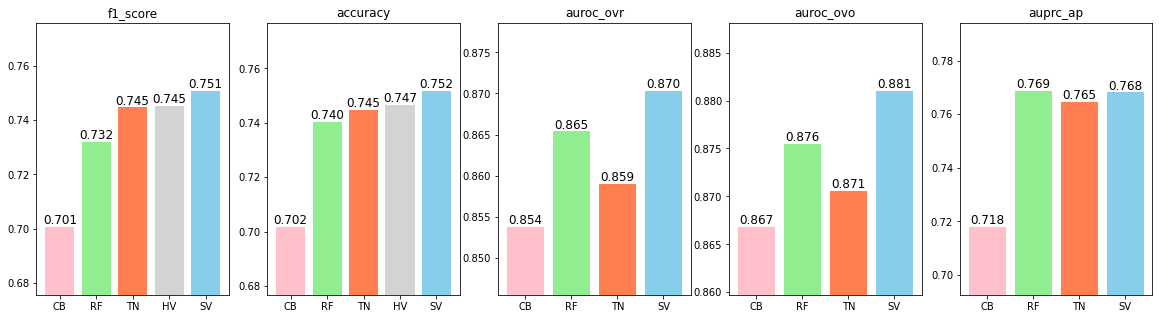

In [59]:
# vanilla + hard ,soft
proba_list = [result_catboost, result_forest, tabnet_proba, ensemble_soft.predict_proba]
pred_list = [model_catboost.predict, model_forest.predict, model_tabnet.predict,result_hv,ensemble_soft.predict]

Metrics.Compare_Model(proba_list,pred_list,test)

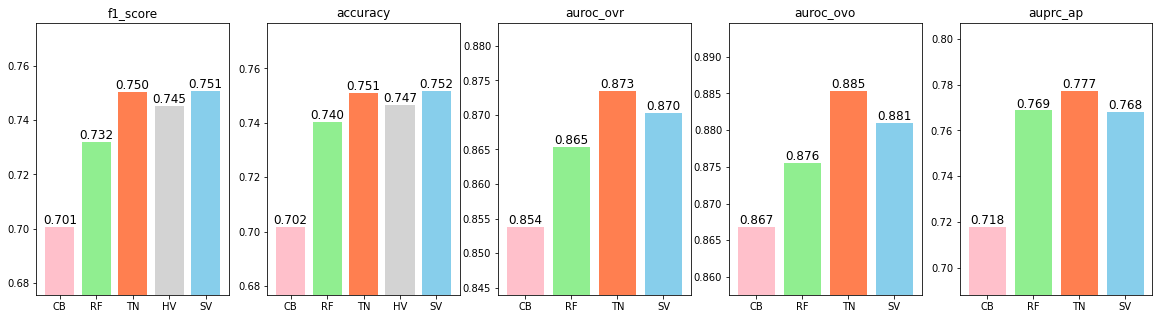

In [60]:
# best + hard ,soft

proba_list = [best_cat.predict_proba,best_rf.predict_proba,best_tabnet.predicted_proba,ensemble_soft.predict_proba]
pred_list = [best_cat.predict, best_rf.predict, best_tabnet.predict ,result_hv,ensemble_soft.predict]

Metrics.Compare_Model(proba_list,pred_list,test)

## Graph for Unbalanced Dataset


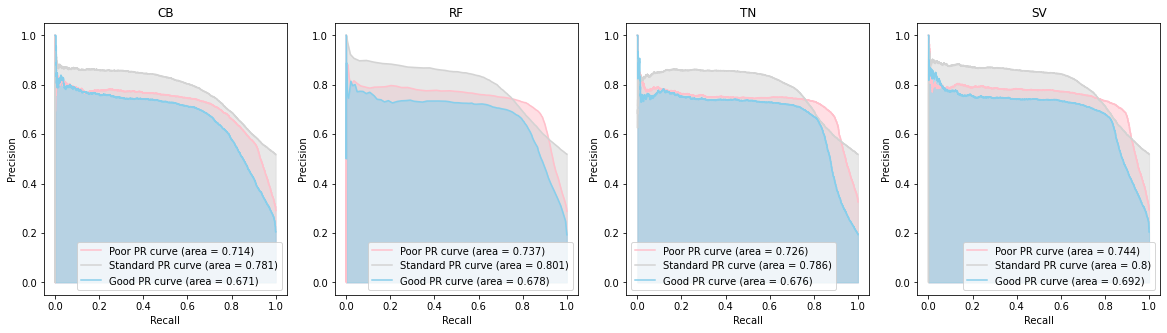

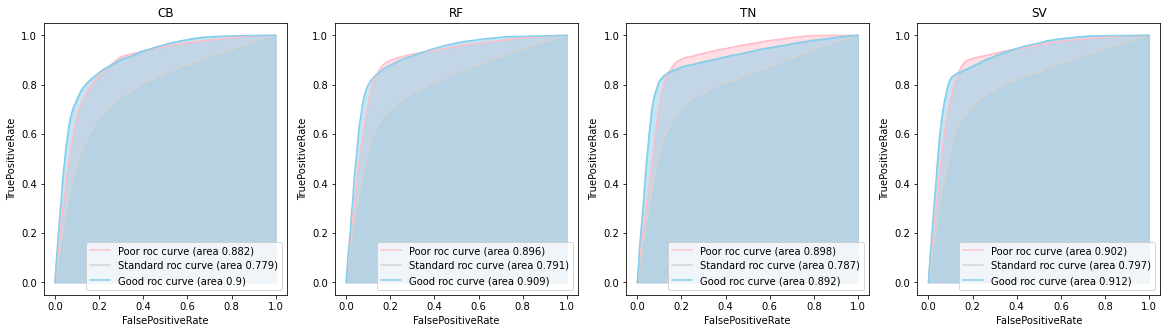

In [61]:
# PR Curve & ROC Curve (Vanilla data)
proba_list = [result_catboost,result_forest,tabnet_proba, ensemble_soft.predict_proba]
Metrics.PR_Curve(proba_list,test)
Metrics.ROC_Curve(proba_list,test)

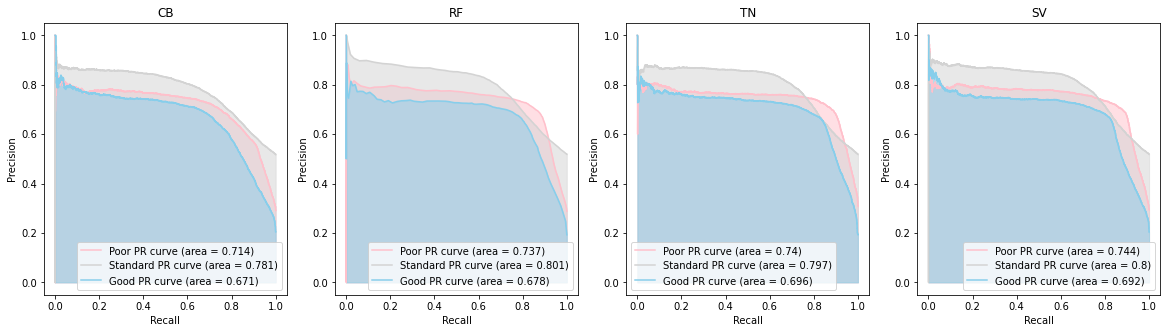

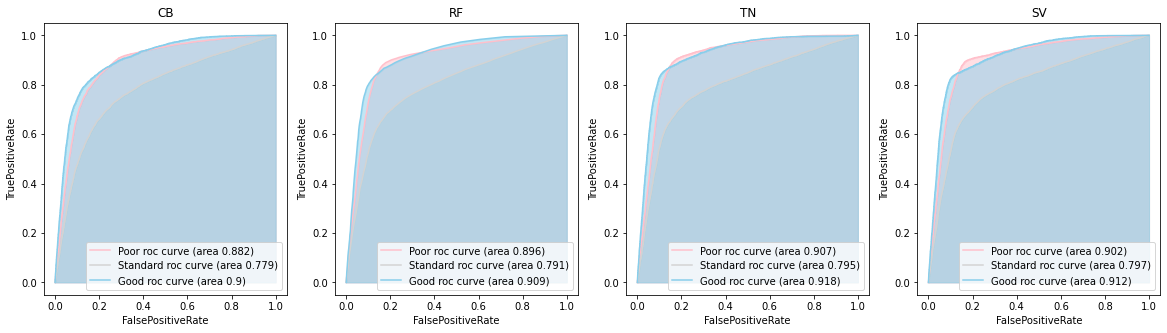

In [62]:
# PR Curve & ROC Curve (Best Model)
proba_list = [best_cat.predict_proba,best_rf.predict_proba,best_tabnet.predicted_proba,ensemble_soft.predict_proba]
Metrics.PR_Curve(proba_list,test)
Metrics.ROC_Curve(proba_list,test)

## Confusion Metrics


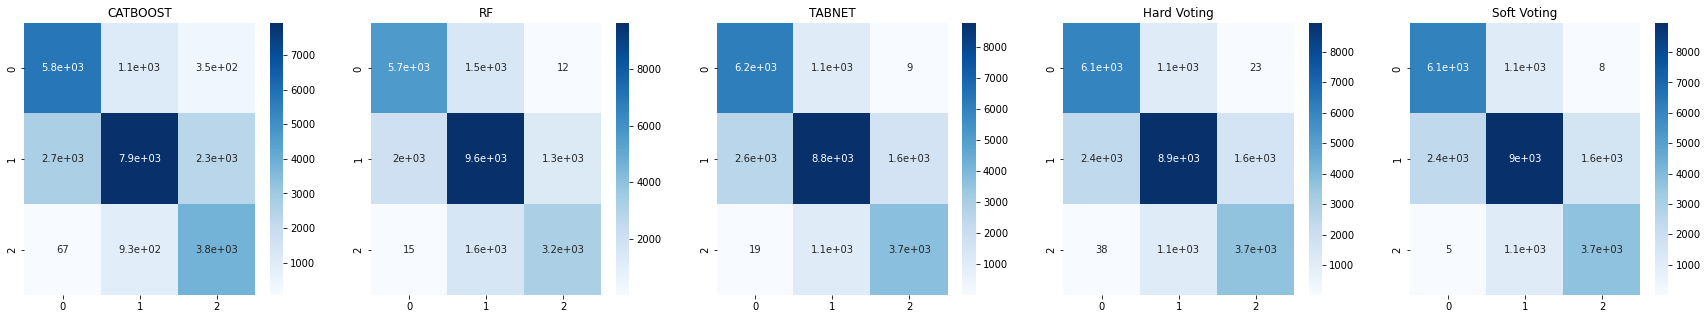

In [75]:
# vanilla version
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5 , figsize = (30,5))
predict_dict = {
    "CATBOOST": model_catboost.predict,
    "RF": model_forest.predict,
    "TABNET": model_tabnet.predict,
    "Hard Voting": result_hv,
    "Soft Voting": ensemble_soft.predict
}

for i in range(0, 5):
    cf_matrix = confusion_matrix(test['Credit_Score'], list(predict_dict.values())[i].iloc[:, 1])
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=axes[i])
    ax.set_title(list(predict_dict.keys())[i])

plt.show()

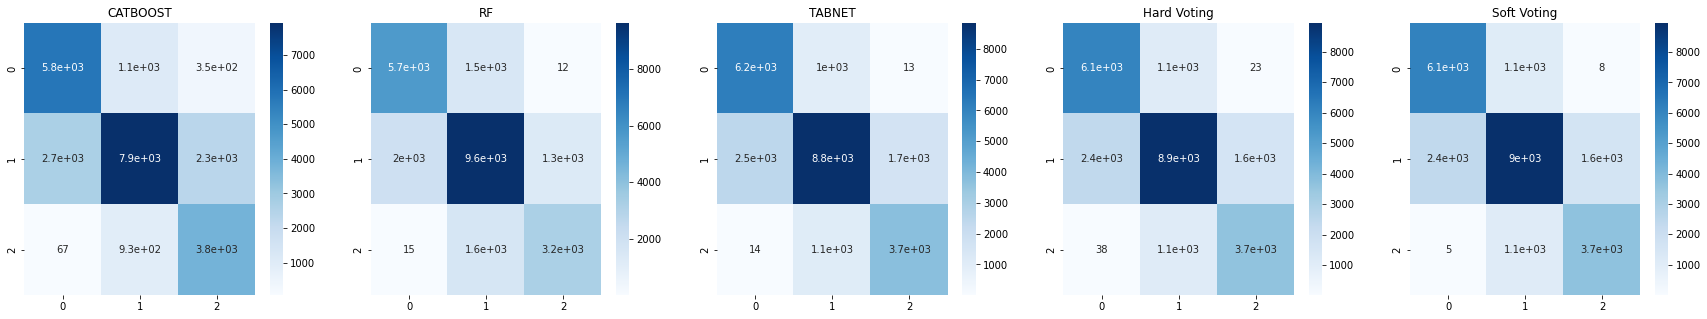

In [76]:
# best model version
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 5 , figsize = (30,5))
predict_dict = {
    "CATBOOST": best_cat.predict,
    "RF": best_rf.predict,
    "TABNET": best_tabnet.predict,
    "Hard Voting": result_hv,
    "Soft Voting": ensemble_soft.predict
}

for i in range(0, 5):
    cf_matrix = confusion_matrix(test['Credit_Score'], list(predict_dict.values())[i].iloc[:, 1])
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', ax=axes[i])
    ax.set_title(list(predict_dict.keys())[i])

plt.show()